In [4]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [8]:
cats_dir = '/home/rt2122/Data/detected_cats/act_ros_rot/'
cats_files = next(os.walk(cats_dir))[-1]

In [26]:
def extract_stats_from_df(df_name):
    import numpy as np
    import pandas as pd
    
    df = pd.read_csv(df_name)
    
    stat_df = {}
    stat_df['all'] = len(df)
    stat_df['all_tp'] = np.count_nonzero(df['status'] == 'tp')
    stat_df['all_fn'] = np.count_nonzero(df['status'] == 'fn')
    stat_df['fp'] = np.count_nonzero(df['status'] == 'fp')
    
    for cat in set(df['catalog']):
        if not (type(cat) == type('')):
            continue
        
        cur_df = df[df['catalog'] == cat]
        cur_df.index = np.arange(len(cur_df))
            
        stat_df[cat+'_tp'] = np.count_nonzero(cur_df['status'] == 'tp')
        stat_df[cat+'_fn'] = np.count_nonzero(cur_df['status'] == 'fn')
        stat_df[cat+'_recall'] = stat_df[cat+'_tp'] / len(cur_df)
    
    return stat_df

In [29]:
def stats_by_epoch(dir_name):
    import os
    import pandas as pd
    import numpy as np
    from DS_data_transformation import get_prm
    
    res_df = []
    
    files = next(os.walk(dir_name))[-1]
    for file in files:
        stat_line = extract_stats_from_df(os.path.join(dir_name, file))
        ep = int(get_prm('ep', file))
        res_df.append(pd.DataFrame(stat_line, index=[ep]))
        
    return pd.concat(res_df)

In [30]:
stats_rot = stats_by_epoch('/home/rt2122/Data/detected_cats/act_ros_rot/')

In [84]:
def plot_stats_ep(stats_df, text='', text_coords=[0,0]):
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    
    stats_df = stats_df.sort_index()
    cats_colors = {'planck_z' : 'b', 'planck_no_z' : 'g', 'mcxcwp' : 'r', 'actwp' : 'c'}
    

    fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
    for cat in cats_colors:
        line, = ax[0].plot(stats_df.index, stats_df[cat+'_recall'], c=cats_colors[cat])
        line.set_label(cat)
    
    line, = ax[1].plot(stats_df.index, stats_df['fp'], c='k')
    line.set_label('fp')
    
    ax[0].set_yticks(np.arange(0, 1.1, 0.1), minor=True)
    ax[0].set_yticks(np.arange(0, 1.1, 0.2))
    ax[1].set_yticks(np.arange(0, max(stats_df['fp']), 50), minor=True)
    ax[1].set_yticks(np.arange(0, max(stats_df['fp']), 100))
    
    for i in range(2):
        ax[i].legend()
        ax[i].set_xticks(stats_df.index[4::5])
        ax[i].set_xticks(stats_df.index, minor=True)
        ax[i].grid(True, which='major')
        ax[i].grid(True, which='minor', alpha=0.2)
    
    ax[1].set_xlabel('epochs')
    ax[0].set_ylabel('recall')
    ax[1].set_ylabel('fp')
    ax[1].text(*text_coords, text, c='r', size=20)


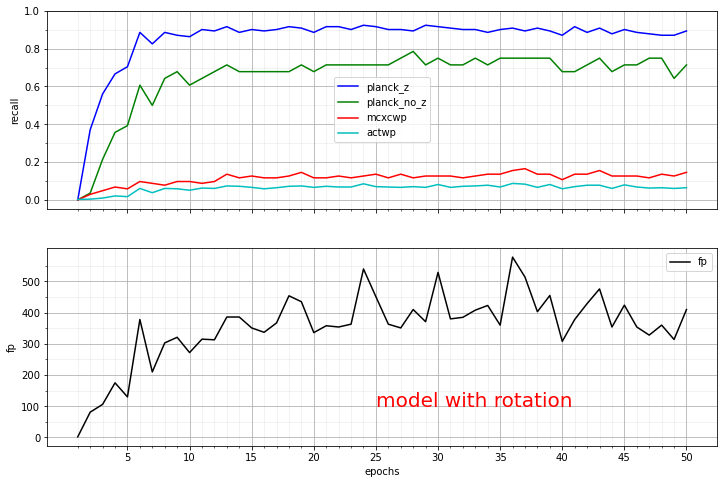

In [86]:
plot_stats_ep(stats_rot, text='model with rotation', text_coords=[25, 100])